In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from scipy import sparse

from sklearn.cluster import KMeans
from kneed import KneeLocator



In [34]:
df = pd.read_csv('/Users/abhishekwaghchaure/Desktop/CreditCardAnalysis/Datasets/CleanedBankChurners.csv')
df.head(5)

Unnamed: 0     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0           0  Existing Customer            45      M                3   
1           1  Existing Customer            49      F                5   
2           2  Existing Customer            51      M                3   
3           3  Existing Customer            40      F                4   
4           4  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School  Not-Specified  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

In [35]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3  Not-Specified  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

## Clustering

In [37]:
features = [
    "Customer_Age",
    "Credit_Limit",
    "Total_Trans_Amt",
    "Avg_Utilization_Ratio",
    "Total_Revolving_Bal"
]
clustering_data = df[features]
clustering_data.head()

Customer_Age  Credit_Limit  Total_Trans_Amt  Avg_Utilization_Ratio  \
0            45       12691.0             1144                  0.061   
1            49        8256.0             1291                  0.105   
2            51        3418.0             1887                  0.000   
3            40        3313.0             1171                  0.760   
4            40        4716.0              816                  0.000   

   Total_Revolving_Bal  
0                  777  
1                  864  
2                    0  
3                 2517  
4                    0

## Feature Selection for Clustering

In [38]:
## Using Filter method approach -- coorelation
numeric_features = df.select_dtypes(include = 'number')
numeric_features.head()

Customer_Age  Dependent_count  Months_on_book  Total_Relationship_Count  \
0            45                3              39                         5   
1            49                5              44                         6   
2            51                3              36                         4   
3            40                4              34                         3   
4            40                3              21                         5   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       1                      3       12691.0   
1                       1                      2        8256.0   
2                       1                      0        3418.0   
3                       4                      1        3313.0   
4                       1                      0        4716.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                  777          11914.0                 1.335   
1                  864           7392.0                 1.541   
2                    0           3418.0                 2.594   
3                 2517            796.0                 1.405   
4                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

In [39]:
threshold = 0.01
var_thresh = VarianceThreshold(threshold)
var_thresh.fit(numeric_features)

VarianceThreshold(threshold=0.01)

In [40]:
# Selecting high-variance numeric features
high_variance_numeric_features = numeric_features.columns[var_thresh.get_support()]
print("Selected Numeric Features:", high_variance_numeric_features)

Selected Numeric Features: Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


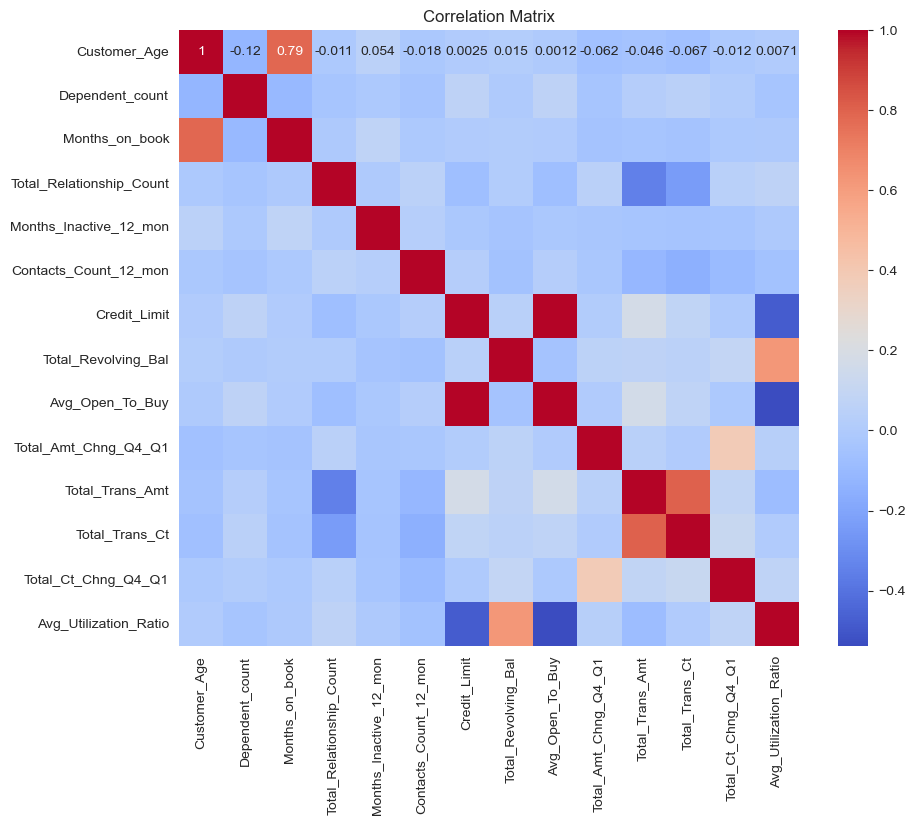

In [41]:
# Correlation Analysis for Numeric Features
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [42]:
len(correlation_matrix.columns)

14

In [43]:
correlation_threshold = 0.85
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(correlation_matrix.columns[i])

In [44]:
final_numeric_features = [f for f in high_variance_numeric_features if f not in correlated_features]
print("Final Numeric Features:", final_numeric_features)

Final Numeric Features: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


In [45]:
len(final_numeric_features)

13

In [73]:
df[final_numeric_features].head()

Customer_Age  Dependent_count  Months_on_book  Total_Relationship_Count  \
0            45                3              39                         5   
1            49                5              44                         6   
2            51                3              36                         4   
3            40                4              34                         3   
4            40                3              21                         5   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       1                      3       12691.0   
1                       1                      2        8256.0   
2                       1                      0        3418.0   
3                       4                      1        3313.0   
4                       1                      0        4716.0   

   Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0                  777                 1.335             1144              42   
1                  864                 1.541             1291              33   
2                    0                 2.594             1887              20   
3                 2517                 1.405             1171              20   
4                    0                 2.175              816              28   

   Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0                1.625                  0.061  
1                3.714                  0.105  
2                2.333                  0.000  
3                2.333                  0.760  
4                2.500                  0.000

In [54]:
# categorical_features = [i for i in df.select_dtypes(include = 'object')]
categorical_features = ["Education_Level", "Gender", "Marital_Status"]

In [55]:
one_hot_encoder = OneHotEncoder(drop="first")
encoded_categorical_data = one_hot_encoder.fit_transform(df[categorical_features]).toarray()

In [57]:
# Use Chi-Square Test for categorical features
chi2_selector = SelectKBest(chi2, k="all")  # Retain all categorical features for inspection
chi2_selector.fit(encoded_categorical_data, df["Attrition_Flag"].apply(lambda x: 1 if x == "Attrited Customer" else 0))
chi2_scores = pd.DataFrame({"Feature": one_hot_encoder.get_feature_names_out(), "Chi2_Score": chi2_selector.scores_})
chi2_scores = chi2_scores.sort_values(by="Chi2_Score", ascending=False)
print("\nChi-Square Scores for Categorical Features:")
print(chi2_scores)

# Select categorical features based on high Chi-Square scores
selected_categorical_features = chi2_scores[chi2_scores["Chi2_Score"] > 5]["Feature"]
print("\n" f"Selected Categorical Features: {selected_categorical_features}")


Chi-Square Scores for Categorical Features:
                         Feature  Chi2_Score
0      Education_Level_Doctorate    8.355706
6                       Gender_M    7.443223
7         Marital_Status_Married    3.064753
9          Marital_Status_Single    2.241029
4  Education_Level_Post-Graduate    1.190018
2    Education_Level_High School    1.116349
8   Marital_Status_Not-Specified    0.743541
3          Education_Level_Other    0.698099
1       Education_Level_Graduate    0.572763
5     Education_Level_Uneducated    0.018020

Selected Categorical Features: 0    Education_Level_Doctorate
6                     Gender_M
Name: Feature, dtype: object


In [107]:
print(selected_categorical_features.index)
print(selected_categorical_features)

Index([0, 6], dtype='int64')
0    Education_Level_Doctorate
6                     Gender_M
Name: Feature, dtype: object


In [67]:
numeric_data = df[final_numeric_features]
numeric_data.head()

Customer_Age  Dependent_count  Months_on_book  Total_Relationship_Count  \
0            45                3              39                         5   
1            49                5              44                         6   
2            51                3              36                         4   
3            40                4              34                         3   
4            40                3              21                         5   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       1                      3       12691.0   
1                       1                      2        8256.0   
2                       1                      0        3418.0   
3                       4                      1        3313.0   
4                       1                      0        4716.0   

   Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0                  777                 1.335             1144              42   
1                  864                 1.541             1291              33   
2                    0                 2.594             1887              20   
3                 2517                 1.405             1171              20   
4                    0                 2.175              816              28   

   Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0                1.625                  0.061  
1                3.714                  0.105  
2                2.333                  0.000  
3                2.333                  0.760  
4                2.500                  0.000

In [69]:
# Transform categorical data to include only selected features
# Get corresponding original column indices for selected features
selected_categorical_indices = [
    idx for idx, feature in enumerate(one_hot_encoder.get_feature_names_out())
    if feature in selected_categorical_features.values
]
print(selected_categorical_indices)

[0, 6]


In [105]:
filtered_categorical_data = encoded_categorical_data[:, selected_categorical_indices]
print(filtered_categorical_data.shape)

(10127, 2)


In [89]:
# Combined numeric and selected categorical features
processed_data = hstack([
    StandardScaler().fit_transform(df[final_numeric_features]),  # Scale selected numeric features
    sparse.csr_matrix(filtered_categorical_data)  # Add selected categorical features
])

In [100]:
print(processed_data.toarray()[0:5])
print((processed_data).toarray().shape[1])

[[-1.65405580e-01  5.03368127e-01  3.84620878e-01  7.63942609e-01
  -1.32713603e+00  4.92403766e-01  4.46621903e-01 -4.73422218e-01
   2.62349444e+00 -9.59706574e-01 -9.73895182e-01  3.83400260e+00
  -7.75882235e-01  0.00000000e+00  1.00000000e+00]
 [ 3.33570383e-01  2.04319867e+00  1.01071482e+00  1.40730617e+00
  -1.32713603e+00 -4.11615984e-01 -4.13666521e-02 -3.66666822e-01
   3.56329284e+00 -9.16432607e-01 -1.35734038e+00  1.26085729e+01
  -6.16275655e-01  0.00000000e+00  0.00000000e+00]
 [ 5.83058365e-01  5.03368127e-01  8.96451285e-03  1.20579050e-01
  -1.32713603e+00 -2.21965548e+00 -5.73697797e-01 -1.42685834e+00
   8.36721381e+00 -7.40981694e-01 -1.91120566e+00  6.80786367e+00
  -9.97154993e-01  0.00000000e+00  1.00000000e+00]
 [-7.89125535e-01  1.27328340e+00 -2.41473064e-01 -5.22784510e-01
   1.64147829e+00 -1.31563573e+00 -5.85251078e-01  1.66168570e+00
   2.94284341e+00 -9.51758294e-01 -1.91120566e+00  6.80786367e+00
   1.75968594e+00  0.00000000e+00  0.00000000e+00]
 [-7

## Clustering

In [104]:
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data)
    inertia.append(kmeans.inertia_)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


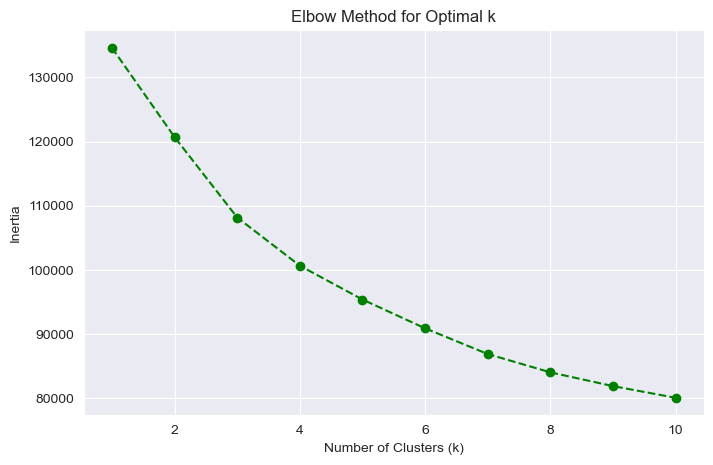

In [113]:
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o', linestyle='--', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

## Based on the figure we can take number of clusters to be 4 but we can do this by knee locator

In [117]:
k1 = KneeLocator(range_clusters, inertia, curve='convex', direction='decreasing')
print(k1.elbow)

4


In [138]:
label_set = set()
for i in range(len(kmeans.labels_)):
    label_set.add(kmeans.labels_[i])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [140]:
kmeans_final = KMeans(n_clusters = 4,random_state=42)
kmeans_final.fit(processed_data)
print(kmeans_final.labels_)

[2 3 3 ... 2 2 3]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [142]:
label_set = set()
for i in range(len(kmeans_final.labels_)):
    label_set.add(kmeans_final.labels_[i])
print(label_set)

{0, 1, 2, 3}


Cluster Centers (Encoded):
 [[ 1.19576659e+00 -7.26162193e-01  1.09763665e+00  2.10644211e-01
   1.02245811e-01  6.63900009e-02 -2.05880409e-01  1.24948175e-01
  -3.61306847e-02 -4.02576678e-01 -4.10779499e-01 -4.58572196e-02
   1.25686645e-01  5.08247882e-02  4.53856442e-01]
 [-8.73121426e-02  2.96228973e-02 -6.54034826e-02 -1.08824490e+00
  -1.25670486e-01 -2.64172894e-01  7.64394122e-01  2.91496398e-01
   6.71656742e-02  2.26701536e+00  1.58384501e+00  3.76788845e-02
  -4.05299516e-01  3.95387150e-02  6.30148270e-01]
 [-3.17046176e-01  2.61196356e-01 -2.78742241e-01  1.28920291e-01
   2.80403128e-02  1.44860661e-01  3.39190407e-01 -7.41332347e-01
  -1.57745019e-01 -3.36928134e-01 -2.83989229e-01 -1.92364564e-01
  -8.12890530e-01  4.84780158e-02  5.61724915e-01]
 [-4.64839106e-01  2.13355199e-01 -4.46387475e-01  1.25318756e-01
  -5.64575313e-02 -1.09600417e-01 -5.34795730e-01  6.39369565e-01
   1.79109969e-01 -2.09402991e-01  1.98089504e-03  2.36907447e-01
   9.91112770e-01  3.747597

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

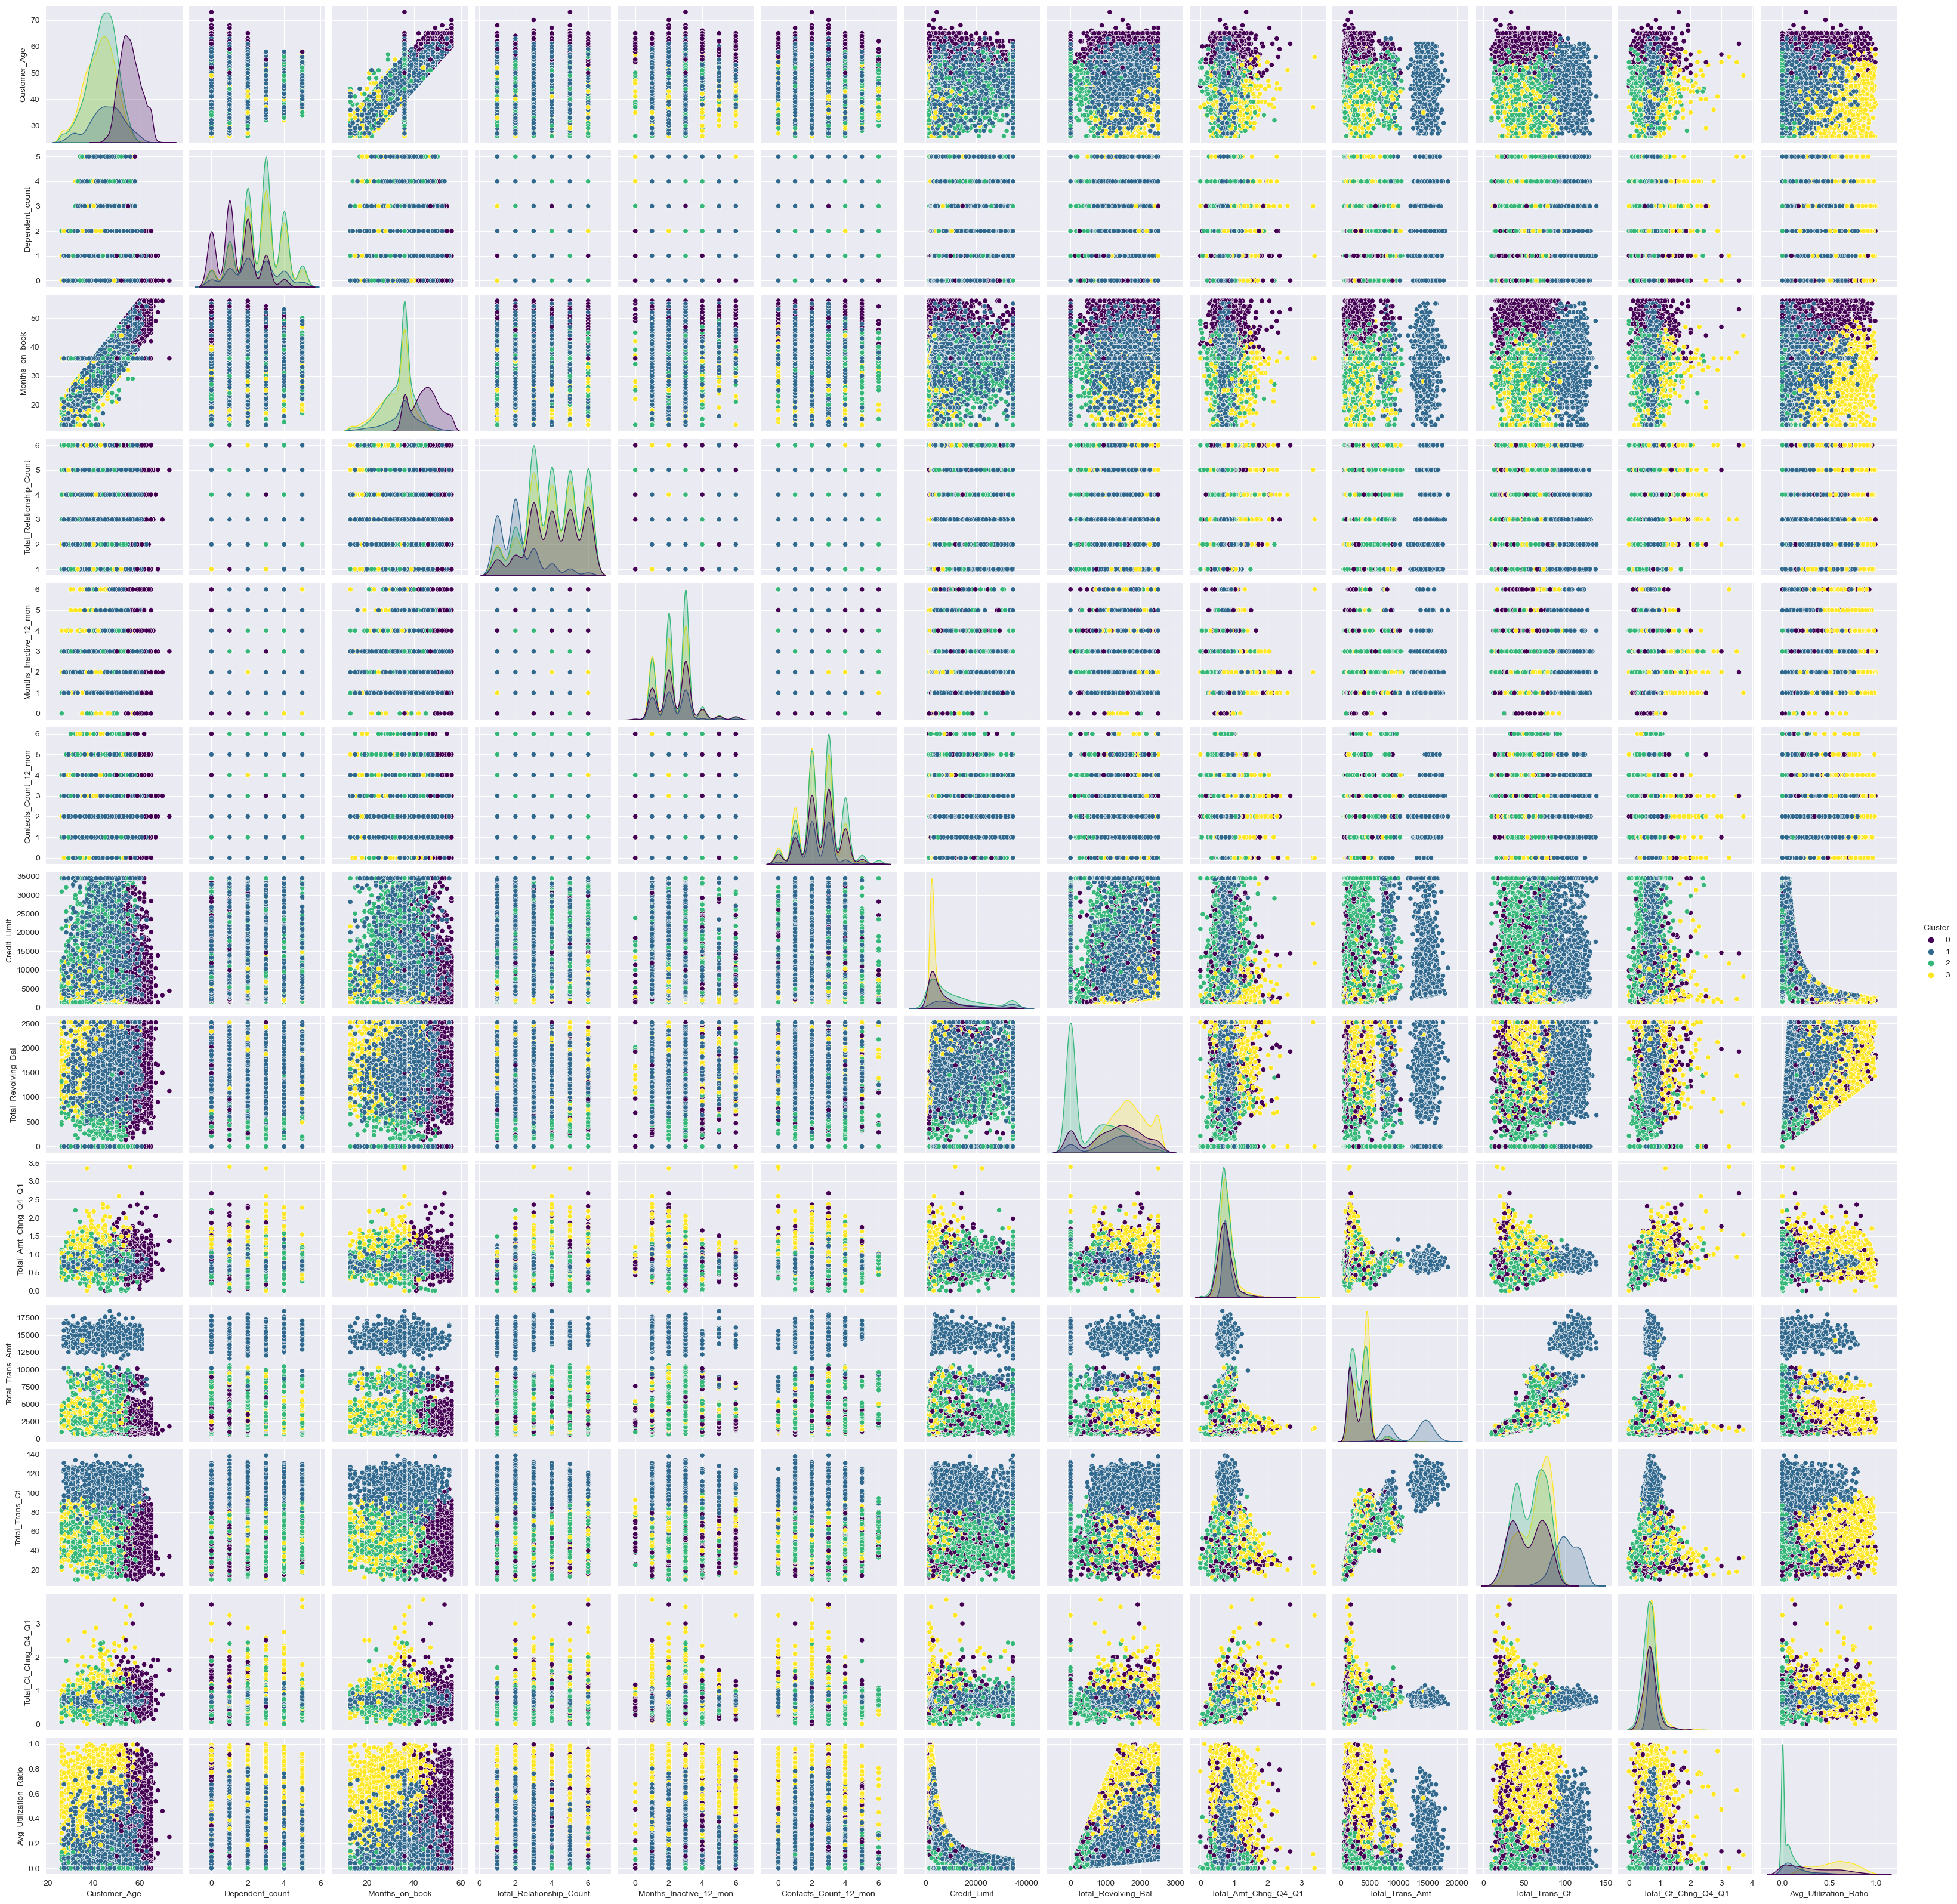

In [143]:
df['Cluster'] = kmeans_final.labels_
print("Cluster Centers (Encoded):\n", kmeans_final .cluster_centers_)
sns.pairplot(df[final_numeric_features + ["Cluster"]], hue="Cluster", diag_kind="kde", palette="viridis")
plt.show()

In [144]:
df.to_csv("/Users/abhishekwaghchaure/Desktop/CreditCardAnalysis/Datasets/Customer_Segmentation_With_Selected_Features.csv", index=False)
print("Segmented dataset saved as 'Customer_Segmentation_With_Selected_Features.csv'")

Segmented dataset saved as 'Customer_Segmentation_With_Selected_Features.csv'
